# About : 

**COCO to be prepared for diseased images in the VinBigData dataset. We have to generate a validation set, containing all those diseased cases**.

In [1]:
import sys
print(sys.executable)

/media/HHD_2TB/baurai/aditya_pytorch_vm/bin/python3.6


In [2]:
import os
import shutil
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm

import cv2

pd.set_option("max_colwidth", None)

print("Python version used = ", sys.version)
print("Numpy used = ", np.__version__)
print("OpenCV used = ", cv2.__version__)

Python version used =  3.6.9 (default, Oct  9 2020, 08:58:16) 
[GCC 6.3.0 20170516]
Numpy used =  1.19.5
OpenCV used =  4.5.1


In [3]:
os.getcwd()

'/media/HHD_2TB/baurai/detection_II'

In [4]:
DATASET_PATH_VINBIGDATA = "/media/HHD_2TB/vinbigdata_cxr/"
IMAGE_DATASET_PATH_VINBIGDATA = DATASET_PATH_VINBIGDATA + "vinbigdata_coco_chest_xray/train_images/"

In [5]:
all_labels = [
    "Aortic enlargement",
    "Atelectasis",
    "Calcification",
    "Cardiomegaly",
    "Consolidation",
    "ILD",
    "Infiltration",
    "Lung Opacity",
    "Nodule/Mass",
    "Other lesion",
    "Pleural effusion",
    "Pleural thickening",
    "Pneumothorax",
    "Pulmonary fibrosis",
]
all_labels, len(all_labels)

(['Aortic enlargement',
  'Atelectasis',
  'Calcification',
  'Cardiomegaly',
  'Consolidation',
  'ILD',
  'Infiltration',
  'Lung Opacity',
  'Nodule/Mass',
  'Other lesion',
  'Pleural effusion',
  'Pleural thickening',
  'Pneumothorax',
  'Pulmonary fibrosis'],
 14)

In [6]:
map_name_to_id = {
    "Aortic enlargement" : 0,
    "Atelectasis" : 1,
    "Calcification" : 2,
    "Cardiomegaly" : 3,
    "Consolidation" : 4,
    "ILD" : 5,
    "Infiltration" : 6,
    "Lung Opacity" : 7,
    "Nodule/Mass" : 8,
    "Other lesion" : 9,
    "Pleural effusion" : 10,
    "Pleural thickening" : 11,
    "Pneumothorax" : 12,
    "Pulmonary fibrosis" : 13,
}

map_name_to_id

{'Aortic enlargement': 0,
 'Atelectasis': 1,
 'Calcification': 2,
 'Cardiomegaly': 3,
 'Consolidation': 4,
 'ILD': 5,
 'Infiltration': 6,
 'Lung Opacity': 7,
 'Nodule/Mass': 8,
 'Other lesion': 9,
 'Pleural effusion': 10,
 'Pleural thickening': 11,
 'Pneumothorax': 12,
 'Pulmonary fibrosis': 13}

In [7]:
def plot_image(image, figsize = (20, 20), is_rgb = True, title = "", cmap = "gray") : 
    plt.figure(figsize = figsize)
    plt.imshow(image, cmap = cmap)
    plt.suptitle(title)

In [8]:
def plot_images(images, columns = 2, figsize = 20, is_rgb = True, title = "", cmap = "gray", resize_image_shape = None) : 
    rows = len(images)//columns + 1
    figure = plt.figure(figsize = (columns * figsize, rows * figsize))
    for index, image in enumerate(images) : 
        if resize_image_shape is not None : 
            image = cv2.resize(image, resize_image_shape)
        figure.add_subplot(rows, columns, index + 1)
        plt.imshow(image, cmap = cmap)
    plt.suptitle(title)

In [9]:
def draw_bbox(image, box, label, color):   
    alpha = 0.1
    alpha_box = 0.4
    thickness = 3
    overlay_bbox = image.copy()
    overlay_text = image.copy()
    output = image.copy()

    text_width, text_height = cv2.getTextSize(label.upper(), cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)[0]
    
    cv2.rectangle(overlay_bbox, (box[0], box[1]), (box[2], box[3]), color, -1)
    cv2.addWeighted(overlay_bbox, alpha, output, 1 - alpha, 0, output)
    
    cv2.rectangle(overlay_text, (box[0], box[1]-7-text_height), (box[0]+text_width+2, box[1]), (0, 0, 0), -1)
    cv2.addWeighted(overlay_text, alpha_box, output, 1 - alpha_box, 0, output)
    
    cv2.rectangle(output, (box[0], box[1]), (box[2], box[3]), color, thickness)
    cv2.putText(output, label.upper(), (box[0], box[1]-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)
    
    return output

# Explore VinBigData

In [10]:
print(os.listdir(DATASET_PATH_VINBIGDATA))

['vinbigdata_coco_chest_xray', 'train', 'sample_submission.csv', 'train.csv', 'test']


In [11]:
vinbigdata = pd.DataFrame(pd.read_csv(DATASET_PATH_VINBIGDATA + "train.csv"))
print(vinbigdata.shape)
vinbigdata.head()

(67914, 8)


,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN


In [12]:
vinbigdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67914 entries, 0 to 67913
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image_id    67914 non-null  object 
 1   class_name  67914 non-null  object 
 2   class_id    67914 non-null  int64  
 3   rad_id      67914 non-null  object 
 4   x_min       36096 non-null  float64
 5   y_min       36096 non-null  float64
 6   x_max       36096 non-null  float64
 7   y_max       36096 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 4.1+ MB


In [13]:
unique_image_ids = list(vinbigdata.image_id.unique())
print("Number of images = ", len(unique_image_ids))

Number of images =  15000


# Discarding Healthy Images

In [15]:
vinbigdata = vinbigdata[vinbigdata.class_id != 14] 
vinbigdata = vinbigdata.reset_index(drop = True)
unique_image_ids = list(vinbigdata.image_id.unique())
print("Number of images after removing healthy cases = ", len(unique_image_ids))

Number of images after removing healthy cases =  4394


In [16]:
print("Shape = ", vinbigdata.shape)
vinbigdata.head()

Shape =  (36096, 8)


,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,557.0,2352.0,675.0,2484.0


# Val Split

All images are to be taken as validation, as the model is trained on NIH and other datasets.

In [17]:
np.random.shuffle(unique_image_ids)

# Create O/P Directory

In [18]:
output_dir_val = "/media/HHD_2TB/baurai/detection_II/coco_dataset_2/val_images"
if os.path.exists(output_dir_val) == False : 
    os.makedirs(output_dir_val)
    print(f"COCO dataset directory for validation = {output_dir_val}")

In [19]:
label2color = [[59, 238, 119], [222, 21, 229], [94, 49, 164], [206, 221, 133], [117, 75, 3],
                 [210, 224, 119], [211, 176, 166], [63, 7, 197], [102, 65, 77], [194, 134, 175],
                 [209, 219, 50], [255, 44, 47], [89, 125, 149], [110, 27, 100]]
len(label2color)

14

In [20]:
output_annot_json = "/media/HHD_2TB/baurai/detection_II/coco_dataset_2/val_annotations.json"

# Create COCO

  0%|          | 0/4394 [00:00<?, ?it/s]

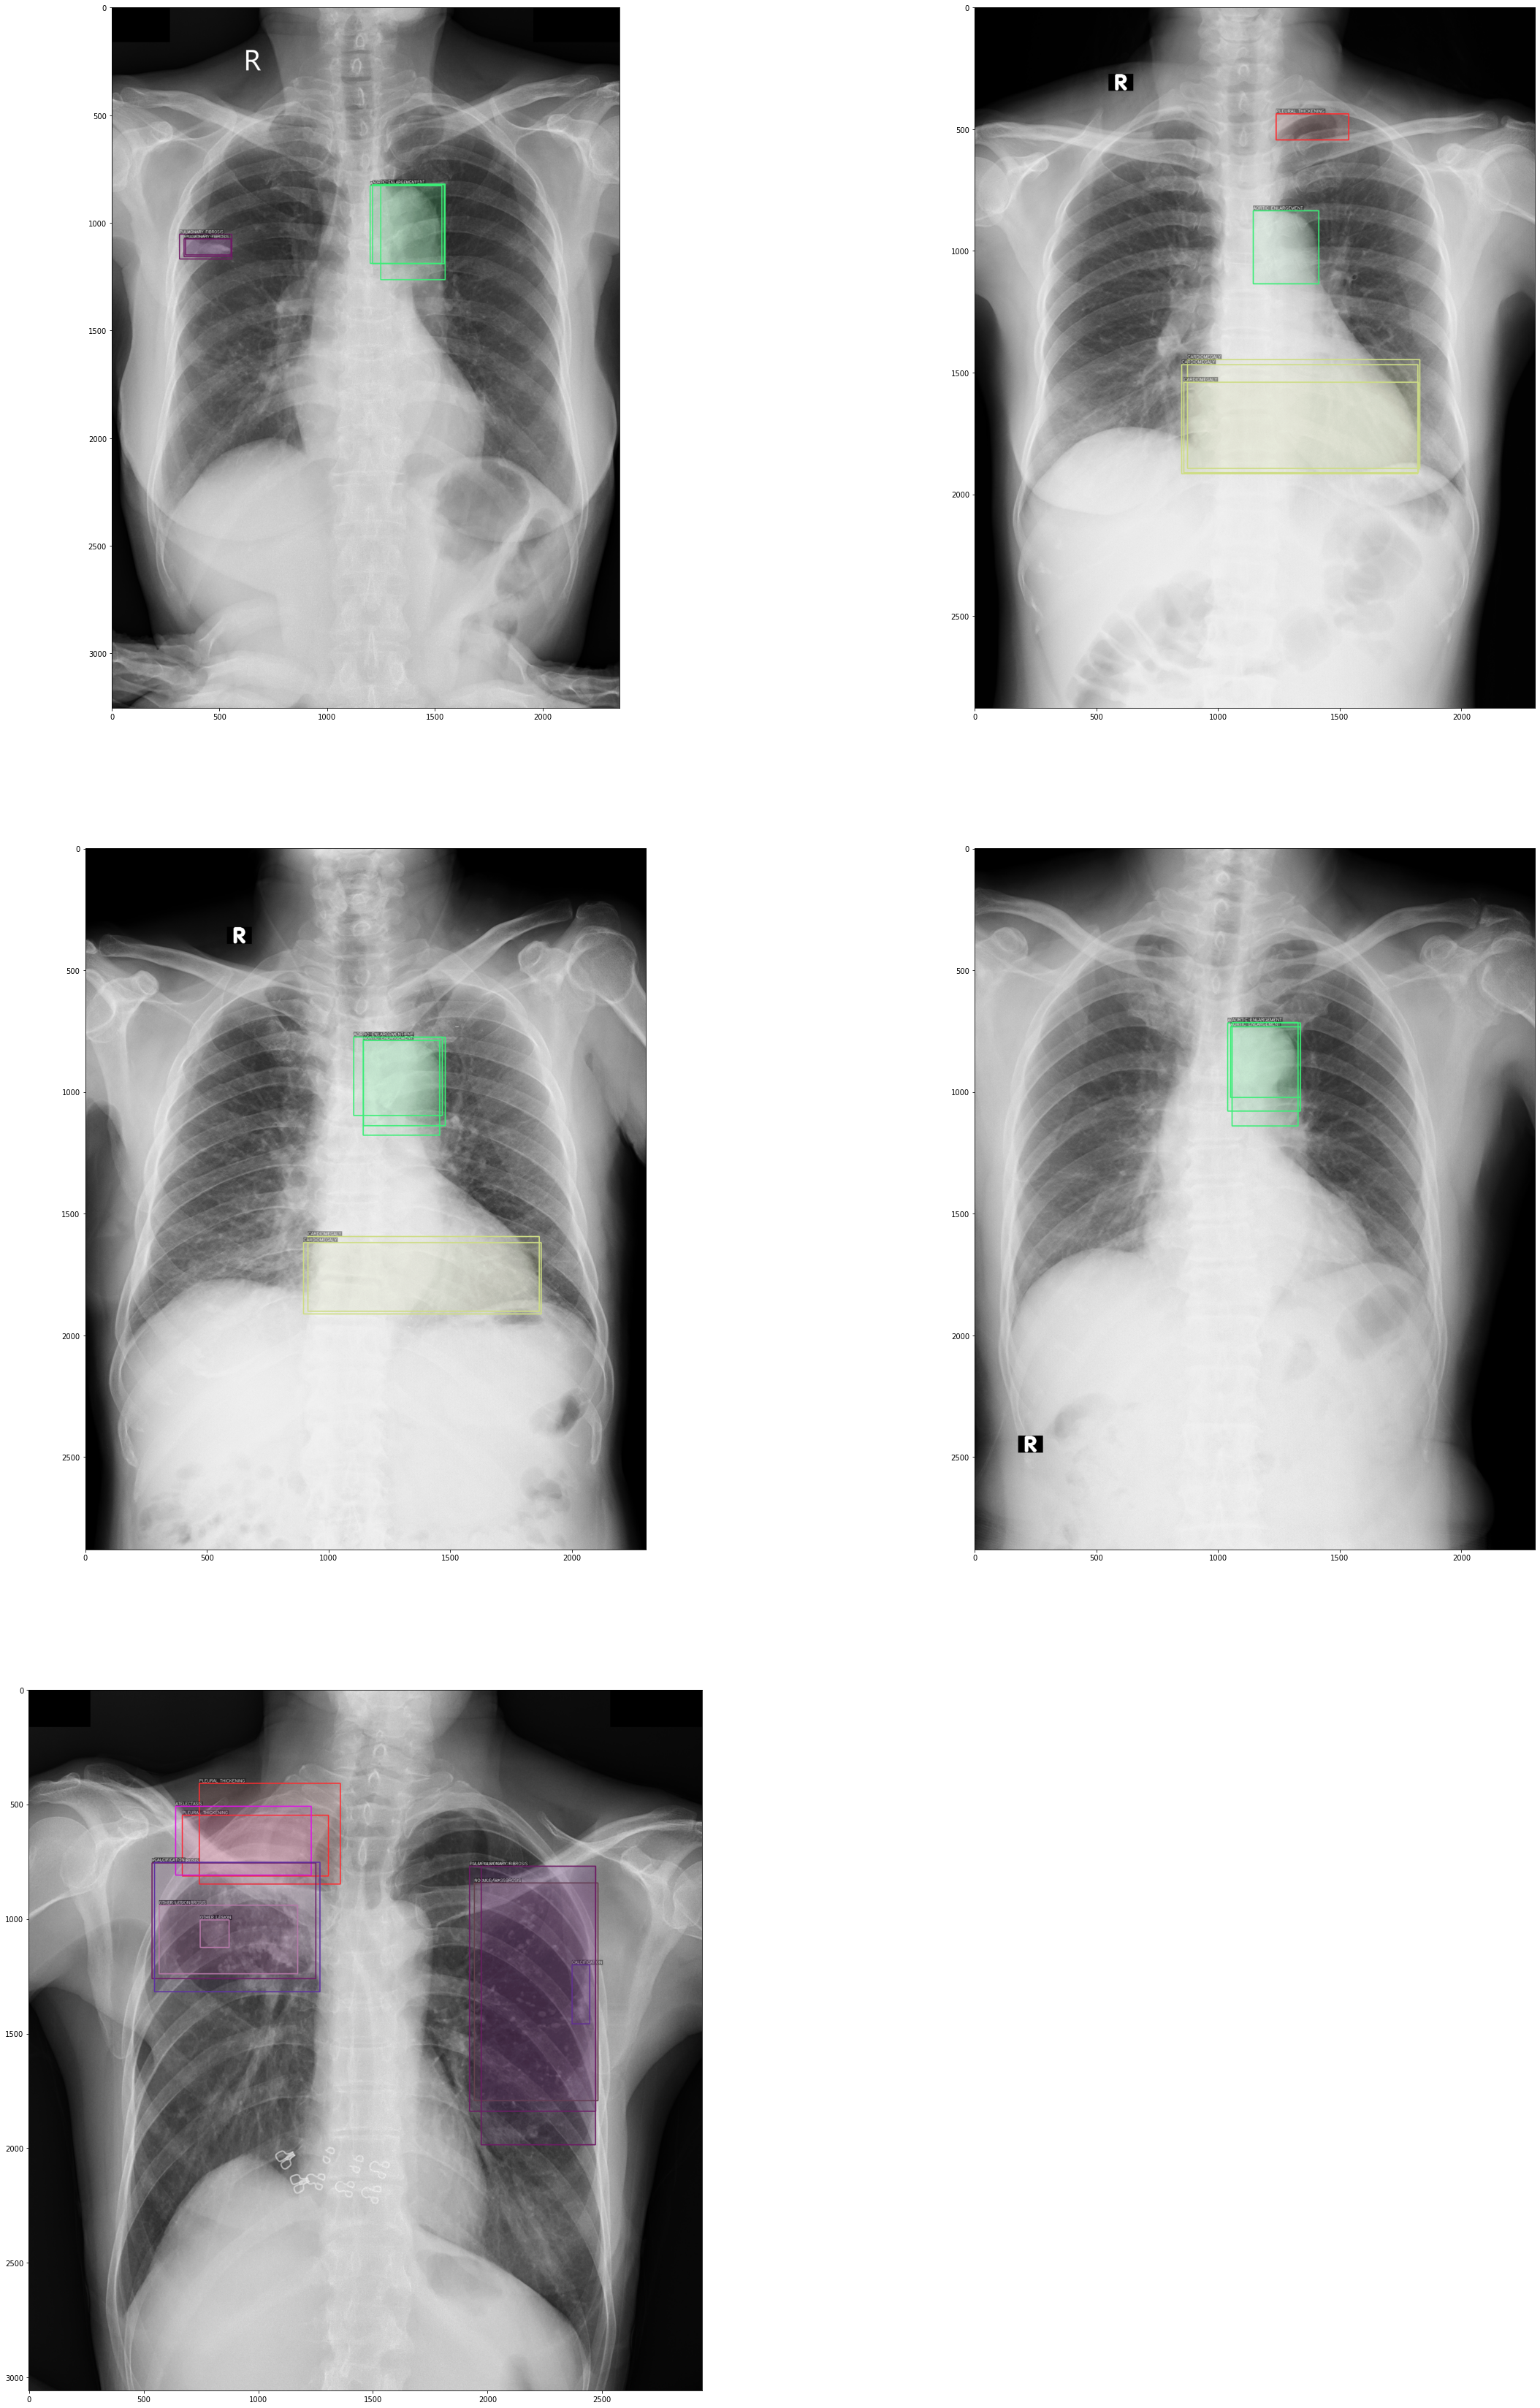

In [21]:
vizualization_images = []

# vinbigdata
index = 0 
json_list = []
for image_id in tqdm(unique_image_ids) : 
    image_name = image_id + ".png"
    image_path = IMAGE_DATASET_PATH_VINBIGDATA + image_name
    
    image_arr = cv2.imread(image_path)
    
    shutil.copy2(image_path, output_dir_val)
    
    non_healthy_image = vinbigdata[vinbigdata.image_id == image_id]
    boxes = non_healthy_image[["x_min", "y_min", "x_max", "y_max"]].to_numpy().tolist()
    labels = non_healthy_image["class_id"].to_numpy().tolist()

    image_dict = {
        "image_id": index,
        "file_name": image_name,
        "height" : image_arr.shape[0],
        "width" : image_arr.shape[1],
        
    }
    ann_list = []
    # label 0  means Nodule/Mass and label 1 means Other_Disease
    for box, label in zip(boxes, labels):
        if label == 8 : 
            label = 0
        elif label == 0 : 
            label = 8
        x_min, y_min, x_max, y_max = (box[0], box[1], box[2], box[3])
        ann_dict = {
            "bbox": [
                round(x_min, 1),
                round(y_min, 1),
                round((x_max - x_min), 1),
                round((y_max - y_min), 1)
            ],
            "category_id": label
        }
        ann_list.append(ann_dict)
    image_dict["annotations"] = ann_list
    json_list.append(image_dict)
    
    # visualize bboxes for every 800th image.
    if index%1000 == 0 : 
        image_before = image_arr.copy()
        for box, label in zip(boxes, labels) : 
            x_min, y_min, x_max, y_max = (box[0], box[1], box[2], box[3])
            color = label2color[int(label)]
            image_before = draw_bbox(image_before, list(np.int_(box)), all_labels[label], color)
        vizualization_images.append(image_before)
    
    index = index + 1

    
plot_images(vizualization_images, cmap = None)

In [22]:
with open(output_annot_json, "w") as f: 
    json.dump(json_list, f, indent = 6)

In [23]:
print("Number of images saved = ", len(os.listdir('/media/HHD_2TB/baurai/detection_II/coco_dataset_2/val_images')))

Number of images saved =  4395
